# 2-qubit tomography and data analysis
## Import stuff

In [1]:
import glob
import pandas as pd
import numpy as np
import scipy as sp
from scipy import linalg
from scipy.optimize import least_squares,minimize
import matplotlib.pyplot as plt
#import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm,ticker,colors,rc,font_manager
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline
import os
fm = font_manager.json_load(os.path.expanduser("~/.cache/matplotlib/fontlist-v310.json"))
fm.findfont("serif", rebuild_if_missing=False)
rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Sans serif']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
plt.rcParams.update({'font.size': 12})

## Some experimental parameters

In [10]:
# number of qubits
n_qbits = 2
# laser repetition rate
R = 8E7
# detector lists
detectors = {'h1':1,'v1':2,'h2':3,'v2':4}
# interesting addresses
addresses = {'h1':[1],'v1':[2],'h2':[3],'v2':[4], #singles
          'h1h2':[1,3],'h1v2':[1,4],'v1h2':[2,3],'v1v2':[2,4], #coincidences
          'h1v1':[1,2],'h2v2':[3,4]} #accidentals
# measurement settings in order
settings = ['zz','zx','zy','xz','xx','xy','yz','yx','yy']

turns = 35 #number of turns of measurements
m_per_turn = 30 #number of measurements per turn

# correct for accidentals? 'theory','exp', or 'no'
acc_corr = 'theory'

## Import Data

In [11]:
# turn lists into addresses
for el in addresses:
    address = 1
    for det in addresses[el]:
        address += 2**(det-1)
    addresses[el] = address

#sort dictionary
addresses = {k: v for k, v in sorted(addresses.items(), key=lambda item: item[1])}
#print(addresses)

# fill lists of columns to import and their labels
# name colunms
cols_to_imp = []
cols_labels = []

for el in addresses:
    cols_labels.append(el)
    cols_to_imp.append(addresses[el])

# find all data files
#fold = '../2020_02_06/ghz/'
dat_files = glob.glob('*.dat')
dat_files = sorted(dat_files) #sort datafiles
#print(dat_files)

counts = [] #will hold total counts for each address, for every setting

for turn in range(turns):
    counts_sing_turn = []
    for dat_file in dat_files:
        df = pd.read_csv(dat_file, sep=' ', header=None, names=cols_labels, usecols=cols_to_imp, skiprows=turn*m_per_turn, nrows=m_per_turn)
        setting_dict = {}
        # loop on turns
        for add in addresses:
            setting_dict[add] = df[add].sum()
        counts_sing_turn.append(setting_dict)
    counts.append(counts_sing_turn)
#print(counts[0])
#print(counts[1])

# now create vectors for experimental frequencies
f_v = []

for i,turn in enumerate(counts):
    f_v_sing_turn = []
    for m_d in counts[i]:
        if acc_corr=='theory':
            hh = max(m_d['h1h2']-m_d['h1']*m_d['h2']/(R*m_per_turn),0)
            hv = max(m_d['h1v2']-m_d['h1']*m_d['v2']/(R*m_per_turn),0)
            vh = max(m_d['v1h2']-m_d['v1']*m_d['h2']/(R*m_per_turn),0)
            vv = max(m_d['v1v2']-m_d['v1']*m_d['v2']/(R*m_per_turn),0)
            norm = hh + hv + vh + vv
            f_v_sing_turn.append(hh/norm)
            f_v_sing_turn.append(hv/norm)
            f_v_sing_turn.append(vh/norm)
            f_v_sing_turn.append(vv/norm)
        elif acc_corr=='exp':
            hh = m_d['h1h2']-(m_d['h1v1']+m_d['h2v2'])/2
            hv = m_d['h1v2']-(m_d['h1v1']+m_d['h2v2'])/2
            vh = m_d['v1h2']-(m_d['h1v1']+m_d['h2v2'])/2
            vv = m_d['v1v2']-(m_d['h1v1']+m_d['h2v2'])/2
            norm = hh + hv + vh + vv
            f_v_sing_turn.append(hh/norm)
            f_v_sing_turn.append(hv/norm)
            f_v_sing_turn.append(vh/norm)
            f_v_sing_turn.append(vv/norm)
        elif acc_corr=='no':
            norm = m_d['h1h2']+m_d['h1v2']+m_d['v1h2']+m_d['v1v2']
            f_v_sing_turn.append(m_d['h1h2']/norm)
            f_v_sing_turn.append(m_d['h1v2']/norm)
            f_v_sing_turn.append(m_d['v1h2']/norm)
            f_v_sing_turn.append(m_d['v1v2']/norm)
        else: print('Error with understanding if we want to correct for accs or not')
    f_v.append(f_v_sing_turn)
#print(f_v[0])
#print(f_v[1])

## Gamma matrices

In [12]:
# Pauli matrices
s0 = np.eye(2)
sx = np.array([[0,1],[1,0]])
sy = np.array([[0,-1j],[1j,0]])
sz = np.array([[1,0],[0,-1]])
pm = [s0,sx,sy,sz]

gammas = [] #will hold all 16 gammas
for i in pm:
    for k in pm:
        gammas.append(np.kron(i,k))
#print(gammas)

## Projectors

In [13]:
proj = [] #will hold all 36 projectors

# fill proj
for s in settings:
    psi = []
    for lett in s:
        if lett == 'x':
            psi.append(np.linalg.eig(sx)[1])
        elif lett == 'y':
            psi.append(np.linalg.eig(sy)[1])
        elif lett == 'z':
            psi.append(np.linalg.eig(sz)[1])
        else: print('Wrong setting definition!')
    for vec in psi[0]:
        for vec1 in psi[1]:
            proj.append(np.kron(vec,vec1))

## B matrix

In [14]:
B = np.zeros((4*len(settings),len(gammas)),dtype=complex)

# fill B
for i,g in enumerate(gammas):
    for k,vector in enumerate(proj):
        #print(vector.T@g@vector)
        B[k,i] = vector.conj().T@g@vector

# define inverted B matrix
B_inv = np.linalg.inv((B.conj().T)@B)@(B.conj().T)

In [15]:
def sigma_N(j,N):
    if j<0 or j>N**2-1:
        print('sigma_N: j out of range for SU(N)')
    
    m = np.int(np.fix(j/N))
    n = np.int(j%N)
    tmp1 = np.zeros([N,1])
    tmp2 = np.zeros([N,1])
    tmp1[m] = 1
    tmp2[n] = 1
    
    if m<n:
        matrix = (np.outer(tmp1,tmp2.conj().transpose())+np.outer(tmp2,tmp1.conj().transpose()))*np.sqrt(N/2.0)
    elif m>n:
        matrix = 1j*(np.outer(tmp1,tmp2.conj().transpose())-np.outer(tmp2,tmp1.conj().transpose()))*np.sqrt(N/2.0)
    elif (m+1)<N:
        z=np.zeros(N)
        for i in range(m+1):
            z[i] = 1
        matrix = -(np.sqrt(N/((m+1.0)**2+m+1.0)))*np.diag(z)
        matrix[m+1,m+1] = (m+1.0)*(np.sqrt(N/((m+1.0)**2+m+1.0)))
    else: #n=m=N
        matrix = np.matrix(np.identity(N))
    
    return matrix

def B_matrix(projectors):
    dim_m = np.shape(projectors)[1]
    dim_b = dim_m**2
    tmp = np.zeros([dim_b,dim_b])+0j
    for i in range(dim_b):
        for j in range(dim_b):
            tmp[i][j] = np.inner(projectors[i],np.inner(sigma_N(j,dim_m),projectors[i].conj().transpose()))
    b = tmp.transpose()
    
    return b

B = B_matrix(proj)
B_inv = np.linalg.inv((B.conj().T)@B)@(B.conj().T)
print(np.shape(B), np.shape(B_inv))

(16, 16) (16, 16)


## LINEAR INVERSION - Density matrix

In [15]:
rho_lin = [np.zeros(np.shape(gammas[0]),dtype=complex) for i in range(turns)]

for turn in range(turns):
    #print(f_v[turn])
    for v,freq in enumerate(f_v[turn]):
        for m,gam in enumerate(gammas):
            rho_lin[turn] += B_inv[m,v]*gam*freq
#print(rho_lin[0]-rho_lin[1])
rho_lin_mean = np.mean(rho_lin, axis=0) #average rho

## Fidelity

In [16]:
def fidelity_old(state1,state2):
    pure = 0
    if len(np.shape(state1))==1:
        rho1 = np.dot(state1,state1.conj().transpose())
        pure = 1
    elif np.shape(state1)[1] == np.shape(state1)[0]:
        rho1 = state1
    else:
        print("State1 is not a vector or density matrix")

    if len(np.shape(state2))==1:
        rho2 = np.dot(state2,state2.conj().transpose())
        pure = 1
    elif np.shape(state2)[1] == np.shape(state2)[0]:
        rho2 = state2
    else:
        print("State1 is not a vector or density matrix")

    rho1 = rho1 / np.trace(rho1)
    rho2 = rho2 / np.trace(rho2)

    rho1 = (rho1+rho1.conj().transpose())/2


    if pure:
        val = np.trace(np.dot(rho1,rho2))
    else:
        val = np.trace(sp.linalg.sqrtm(sp.linalg.sqrtm(rho1)@rho2@sp.linalg.sqrtm(rho1)))**2
#        tmp = sp.linalg.sqrtm(rho1)
#        a = np.dot(tmp,np.dot(rho2,tmp))
#        ev = np.linalg.eig(a)[0]
#        val = np.sum(ev**(0.5))**2
    val = np.real(val)

    return val

def fidelity(state1,state2):

    rho1 = state1
    rho2 = state2

#    rho1 = (rho1+rho1.conj().transpose())/2
    val = (np.trace(sp.linalg.sqrtm(sp.linalg.sqrtm(rho1)@rho2@(sp.linalg.sqrtm(rho1)))))**2
#        tmp = sp.linalg.sqrtm(rho1)
#        a = np.dot(tmp,np.dot(rho2,tmp))
#        ev = np.linalg.eig(a)[0]
#        val = np.sum(ev**(0.5))**2
    val = np.real(val)

    return val

phi_plus = np.array([[1,0,0,1],[0,0,0,0],[0,0,0,0],[1,0,0,1]]) / 2


## Concurrence and Tangle

In [17]:
def concurrence(rho):
    if min(np.shape(rho))==1:
        rho = np.dot(rho,rho.conj().transpose())
        #psi??, I think there something wrong here in m files.

    Z = np.array([[0,0,0,-1],[0,0,1,0],[0,1,0,0],[-1,0,0,0]])
    R = np.dot(rho,np.dot(Z,np.dot(rho.conj(),Z)))
    [r,right] = np.linalg.eig(R)
    #left = np.linalg.inv(right)
    r = np.real(r)

    tmp = np.sort(np.sqrt(r+0j))
    C = np.real(tmp[3]-tmp[2]-tmp[1]-tmp[0])
    C = np.max([C,0])

    return C

def tangle(rho):
    C = concurrence(rho)
    T = C**2

    return T

## Entanglement

In [18]:
def entanglement(rho):
    t = tangle(rho)
    x = (1 + np.sqrt(1-t))/2
    if x == 0:
        E = 0
    elif x == 1:
        E = 1
    else:
        E = -x*np.log2(x) - (1-x)*np.log2(1-x)

    return E

## Entropy and Linear entropy

In [19]:
def entropy(rho):
    [D,ignore] = np.linalg.eig(rho)
    E = np.real(D)
    S = 0
    for a in range(len(E)):
        if E[a] > 0:
            S = S - E[a]*np.log2(E[a])

    return S

def linear_entropy(rho):
    if min(np.shape(rho)) == 1:
        lin_e = 0
    else:
        d = len(rho)
        lin_e = d * np.real(1-np.trace(np.dot(rho,rho)))/(d-1)

    return lin_e

## Negativity

In [20]:
def partial_transpose_first(M,d):
    if np.shape(M)[0] == d:
        val = M.tranpose()
    else:
        Na = np.int(d)
        Nb = np.int(len(M)/d)
        Y = np.zeros([Nb,Nb,Na,Na])+0j
        val = np.zeros([len(M),len(M)])+0j
        for j in range(Nb):
            for k in range(Nb):
                Y[j,k] = M[j*Nb:j*Nb+Na,k*Nb:k*Nb+Na]
        for j in range(Nb):
            for k in range(Nb):
                val[j*Nb:j*Nb+Na,k*Nb:k*Nb+Na] = Y[k,j]

        return val

def partial_transpose(rho,n,D=np.nan):
    if min(np.shape(rho)) == 1:
            rho = np.dot(rho,rho.conj().transpose())

    if D is np.nan:
        n_qubit = np.log2(np.shape(rho)[0])
        if not n_qubit%1:
            D = 2 * np.ones(int(n_qubit))
        else:
            print('dimension of rho is incorrect.')
    if n<0:
        Na = 1.0
        Nb = 1.0
        Nc = np.prod(D)
    elif n==0:
        Na = 1.0
        Nb = D[n]
        Nc = np.prod(D[np.arange(n+1,len(D))])
    elif (n>0)&(n<len(D)):
        Na = np.prod(D[range(n-1)])
        Nb = D[n]
        Nc = np.prod(D[np.arange(n+1,len(D))])
    elif n==len(D):
        Na = np.prod(D[range(n-1)])
        Nb = D[n]
        Nc = 1.0
    elif n>len(D):
        Na = np.prod(D)
        Nb = 1.0
        Nc = 1.0

    if Na==1:
        rv = partial_transpose_first(rho,Nb)
    # I did't check from here
    else:
        sub_sizes = Nb*Nc
        Y = np.zeros([sub_sizes,sub_sizes,Na,Na])+0j
        for j in range(sub_sizes):
            for k in range(sub_sizes):
                Y[j,k] = rho[j*sub_sizes:j*sub_sizes+Na,k*sub_sizes:k*sub_sizes+Na]

        rv = np.zeros([len(rho),len(rho)])+0j

        for j in range(Na):
            for k in range(Na):
                rv[j*Nb:j*Nb+Na,k*Nb:k*Nb+Na] = partial_transpose_first(Y[j,k],Nb)

    return rv

def negativity(rho):
    if min(np.shape(rho)) == 1:
        rho = np.dot(rho,rho.conj().transpose())

    rho1 = partial_transpose(rho,0)
    val = -2*np.min(np.min(np.real(np.linalg.eig(rho1)[0])),0)

    return val

## Initialize for Maximum likelihood

In [21]:
# find inital guesses for T matrix
def density2tm(rho):
    d = np.shape(rho)[0]
    if d == 1:
        tm = np.real(np.sqrt(rho))
        return tm
    
    tm = np.zeros(np.shape(rho), dtype=complex)
    last_element = rho[d-1,d-1]
    tm[d-1,d-1] = np.real(np.sqrt(last_element))
    if last_element > 0:
        temp = rho[d-1,:d-1]
        tm[d-1,:d-1] = temp/np.sqrt(last_element)
        recurse = rho[:d-1,:d-1] - np.outer(temp.conj().transpose(),temp)/last_element

    else:
        tm[d-1,:d-1] = np.zeros(d-1)
        recurse = rho[:d-1,:d-1]

    tm[:d-1,:d-1] = density2tm(recurse)
        
    return tm   
    
def density2t(rho):
    tm = density2tm(rho)
    d = len(tm)
    
    idx = 0
    cur_length = d
    t = np.zeros(d**2)
    
    for j in range(d):
        t[np.arange(idx,idx+cur_length)] = np.real(np.diag(tm,-j))
        idx = idx + cur_length
        if j>0:
            t[np.arange(idx,idx+cur_length)] = np.imag(np.diag(tm,-j))
            idx = idx + cur_length
        cur_length = cur_length -1
        
    return t

def make_positive(rho_in):
    D,V = np.linalg.eig(rho_in)
    rho = np.zeros(np.shape(rho_in))
    for j in range(len(D)):
        rho = rho + np.abs(D[j])*np.outer(V[:,j],V[:,j].conj().transpose())
    rho = (rho + rho.conj().transpose())/2.0
    
    return rho

## Maximum Likelyhood

In [25]:
%%time
opt_turns = turns
# physical density matrix
def t_matrix(t):
    d = np.int(np.sqrt(len(t)))
    
    idx = 0
    cur_length = d
    tm = np.zeros([d,d])
    
    for j in range(np.int(d)):
        tm = tm + 1*np.diag(t[np.arange(idx,idx+cur_length)],-j)
        idx = idx + cur_length
        
        if j>0:
            tm = tm + 1j*np.diag(t[np.arange(idx,idx+cur_length)],-j)
            idx = idx + cur_length
        
        cur_length = cur_length - 1
        
    return tm

def MLrho(t):
    # T matrix
    Tm = t_matrix(t)
    return Tm.conj().T@Tm/(np.trace(Tm.conj().T@Tm))

# likelyhood function
def LikeFun(t,proj,data):
    like = .0
    for v,vec in enumerate(proj):
        #like += np.real(vec.conj().T@MLrho(t)@vec-data[v])/np.sqrt(np.real(2*vec.conj().T@MLrho(t)@vec))
        like += (vec.conj().T@MLrho(t)@vec-data[v])**2/(2*vec.conj().T@MLrho(t)@vec)
    return np.real(like)

# minimisation routine
#init = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
init = np.ones(4**2)
min_result = []
#bnd = (-1,1)
#bound = ((bnd,)*(2*n_qbits)**2)
#print(bounds)

##Print callback function
def printx(Xi):
    global Nfeval
    global fout
    fout.write(str(Nfeval) +', t = '+ str(Xi) + '\n' + 'rho = ' + str(MLrho(Xi)) + '\n')
    Nfeval += 1


#fout = open('BFGS_steps.txt','w')

#res = minimize(energy, xyzInit, method='BFGS', jac = energy_der, callback=printx, options={'disp': True})

for turn in range(opt_turns):
    rho0 = make_positive(rho_lin[turn])
    rho0 = rho0/(np.trace(rho0))
    t0 = np.real(density2t(rho0))
#    print(t0)
    Nfeval = 1
#    mini = minimize(LikeFun,init,args=(proj,f_v[turn]), callback=printx, options={'disp': True})
    mini = minimize(LikeFun,t0,args=(proj,f_v[turn]))
    if mini.success:
        min_result.append(mini)

        
#fout.close()

rho_ML = [MLrho(min_result[i].x) for i in range(opt_turns)]
rho_ML_mean = np.mean(rho_ML, axis=0)
#print(rho_ML)

# check optimisation result
print(len([min_result[turn].success for turn in range(opt_turns)]))

35
CPU times: user 4min 30s, sys: 1.49 s, total: 4min 31s
Wall time: 4min 30s


## Print results out

In [26]:
# DENSITY MATRIX
print('\n##########################')
print('#    LINEAR INVERSION    #')
print('##########################\n')

with np.printoptions(precision=3, suppress=True):
    print('Rho = ',rho_lin_mean)
    print('Eigenvalues of rho: ',np.linalg.eig(rho_lin_mean)[0])
    print('Trace of rho: {:.3f}'.format(np.trace(rho_lin_mean)))
    print('Trace of rho²: {:.3f}'.format(np.trace(rho_lin_mean@rho_lin_mean)))
    print('rho - rho²= ',rho_lin_mean-(rho_lin_mean@rho_lin_mean))
#print(np.std(rho_lin, axis=0))

# FIDELITY
fid_list = [fidelity(rho_lin[i],phi_plus) for i in range(len(rho_lin))]
#print('Average fidelity: ',fidelity(rho_lin_mean,phi_plus))
print('Median fidelity: {:.4f}+{:.4f}-{:.4f}'.format(np.median(fid_list),np.percentile(fid_list,50+34.1)
      -np.median(fid_list),np.median(fid_list)-np.percentile(fid_list,50-34.1)))

# CONCURRENCE
conc_list = [concurrence(rho_lin[i]) for i in range(len(rho_lin))]
print('Median concurrence: {:.3f}+{:.3f}-{:.3f}'.format(np.median(conc_list),np.percentile(conc_list,50+34.1)
      -np.median(conc_list),np.median(conc_list)-np.percentile(conc_list,50-34.1)))

# TANGLE
tan_list = [tangle(rho_lin[i]) for i in range(len(rho_lin))]
print('Median tangle: {:.3f}+{:.3f}-{:.3f}'.format(np.median(tan_list),np.percentile(tan_list,50+34.1)
      -np.median(tan_list),np.median(tan_list)-np.percentile(tan_list,50-34.1)))

# ENTANGLEMENT
ent_list = [entanglement(rho_lin[i]) for i in range(len(rho_lin))]
print('Median entanglement: {:.3f}+{:.3f}-{:.3f}'.format(np.median(ent_list),np.percentile(ent_list,50+34.1)
      -np.median(ent_list),np.median(ent_list)-np.percentile(ent_list,50-34.1)))

# ENTROPY
entr_list = [entropy(rho_lin[i]) for i in range(len(rho_lin))]
print('Median entropy: {:.3f}+{:.3f}-{:.3f}'.format(np.median(entr_list),np.percentile(entr_list,50+34.1)
      -np.median(entr_list),np.median(entr_list)-np.percentile(entr_list,50-34.1)))

# LINEAR ENTROPY
lin_entr_list = [linear_entropy(rho_lin[i]) for i in range(len(rho_lin))]
print('Median linear entropy: {:.3f}+{:.3f}-{:.3f}'.format(np.median(lin_entr_list),np.percentile(lin_entr_list,50+34.1)
      -np.median(lin_entr_list),np.median(lin_entr_list)-np.percentile(lin_entr_list,50-34.1)))

# NEGATIVITY
neg_list = [negativity(rho_lin[i]) for i in range(len(rho_lin))]
print('Median negativity: {:.3f}+{:.3f}-{:.3f}'.format(np.median(neg_list),np.percentile(neg_list,50+34.1)
      -np.median(neg_list),np.median(neg_list)-np.percentile(neg_list,50-34.1)))



# DENSITY MATRIX
print('\n############################')
print('#    MAXIMUM LIKELYHOOD    #')
print('############################\n')

with np.printoptions(precision=3, suppress=True):
    print('Rho = ',rho_ML_mean)
    print('Eigenvalues of rho: ',np.linalg.eig(rho_ML_mean)[0])
    print('Trace of rho: {:.3f}'.format(np.trace(rho_ML_mean)))
    print('Trace of rho²: {:.3f}'.format(np.trace(rho_ML_mean@rho_ML_mean)))
    print('rho - rho²= ',rho_ML_mean-(rho_ML_mean@rho_ML_mean))

# FIDELITY
fid_list_ML = [fidelity(rho_ML[i],phi_plus) for i in range(len(rho_ML))]
#print('Average fidelity: ',fidelity(rho_ML_mean,phi_plus))
print('Median fidelity: {:.4f}+{:.4f}-{:.4f}'.format(np.median(fid_list_ML),np.percentile(fid_list_ML,50+34.1)
      -np.median(fid_list_ML),np.median(fid_list_ML)-np.percentile(fid_list_ML,50-34.1)))

# CONCURRENCE
conc_list_ML = [concurrence(rho_ML[i]) for i in range(len(rho_ML))]
print('Median concurrence: {:.3f}+{:.3f}-{:.3f}'.format(np.median(conc_list_ML),np.percentile(conc_list_ML,50+34.1)
      -np.median(conc_list_ML),np.median(conc_list_ML)-np.percentile(conc_list_ML,50-34.1)))

# TANGLE
tan_list_ML = [tangle(rho_ML[i]) for i in range(len(rho_ML))]
print('Median tangle: {:.3f}+{:.3f}-{:.3f}'.format(np.median(tan_list_ML),np.percentile(tan_list_ML,50+34.1)
      -np.median(tan_list_ML),np.median(tan_list_ML)-np.percentile(tan_list_ML,50-34.1)))

# ENTANGLEMENT
ent_list_ML = [entanglement(rho_ML[i]) for i in range(len(rho_ML))]
print('Median entanglement: {:.3f}+{:.3f}-{:.3f}'.format(np.median(ent_list_ML),np.percentile(ent_list_ML,50+34.1)
      -np.median(ent_list_ML),np.median(ent_list_ML)-np.percentile(ent_list_ML,50-34.1)))

# ENTROPY
entr_list_ML = [entropy(rho_ML[i]) for i in range(len(rho_ML))]
print('Median entropy: {:.3f}+{:.3f}-{:.3f}'.format(np.median(entr_list_ML),np.percentile(entr_list_ML,50+34.1)
      -np.median(entr_list_ML),np.median(entr_list_ML)-np.percentile(entr_list_ML,50-34.1)))

# LINEAR ENTROPY
lin_entr_list_ML = [linear_entropy(rho_ML[i]) for i in range(len(rho_ML))]
print('Median linear entropy: {:.3f}+{:.3f}-{:.3f}'.format(np.median(lin_entr_list_ML),np.percentile(lin_entr_list_ML,50+34.1)
      -np.median(lin_entr_list_ML),np.median(lin_entr_list_ML)-np.percentile(lin_entr_list_ML,50-34.1)))

# NEGATIVITY
neg_list_ML = [negativity(rho_ML[i]) for i in range(len(rho_ML))]
print('Median negativity: {:.3f}+{:.3f}-{:.3f}'.format(np.median(neg_list_ML),np.percentile(neg_list_ML,50+34.1)
      -np.median(neg_list_ML),np.median(neg_list_ML)-np.percentile(neg_list_ML,50-34.1)))

print('\n####################')
print('#    COMPARISON    #')
print('####################\n')

with np.printoptions(precision=3, suppress=True):
    print('Fidelity of the two methods: {:.3f}'.format(fidelity(rho_lin_mean,rho_ML_mean)))



##########################
#    LINEAR INVERSION    #
##########################

Rho =  [[ 0.496+0.j    -0.001-0.005j  0.006-0.004j  0.497-0.021j]
 [-0.001+0.005j  0.001+0.j     0.   +0.007j -0.003+0.006j]
 [ 0.006+0.004j  0.   -0.007j -0.   +0.j     0.004+0.007j]
 [ 0.497+0.021j -0.003-0.006j  0.004-0.007j  0.503+0.j   ]]
Eigenvalues of rho:  [ 0.998+0.j  0.008+0.j  0.001-0.j -0.006+0.j]
Trace of rho: 1.000+0.000j
Trace of rho²: 0.995+0.000j
rho - rho²=  [[ 0.002-0.j     0.001+0.j     0.001+0.001j  0.   -0.j   ]
 [ 0.001-0.j     0.001+0.j     0.   +0.007j -0.001+0.j   ]
 [ 0.001-0.001j  0.   -0.007j -0.   +0.j    -0.001+0.001j]
 [ 0.   +0.j    -0.001-0.j    -0.001-0.001j  0.002-0.j   ]]
Median fidelity: 0.9970+0.0005-0.0007
Median concurrence: 0.978+0.008-0.011
Median tangle: 0.957+0.015-0.021
Median entanglement: 0.969+0.011-0.016
Median entropy: 0.091+0.021-0.019
Median linear entropy: 0.006+0.001-0.002
Median negativity: 0.995+0.001-0.001

############################
#    MAXIMU

## Plotting

<ipython-input-30-b3fe7f3b23f7>:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


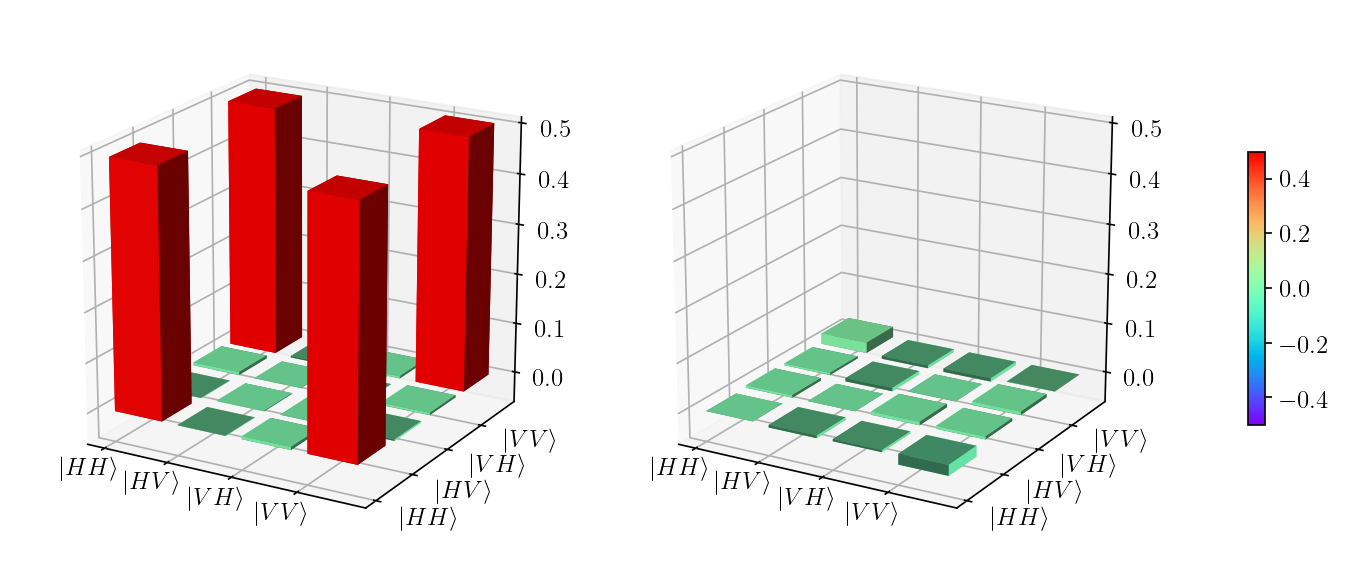

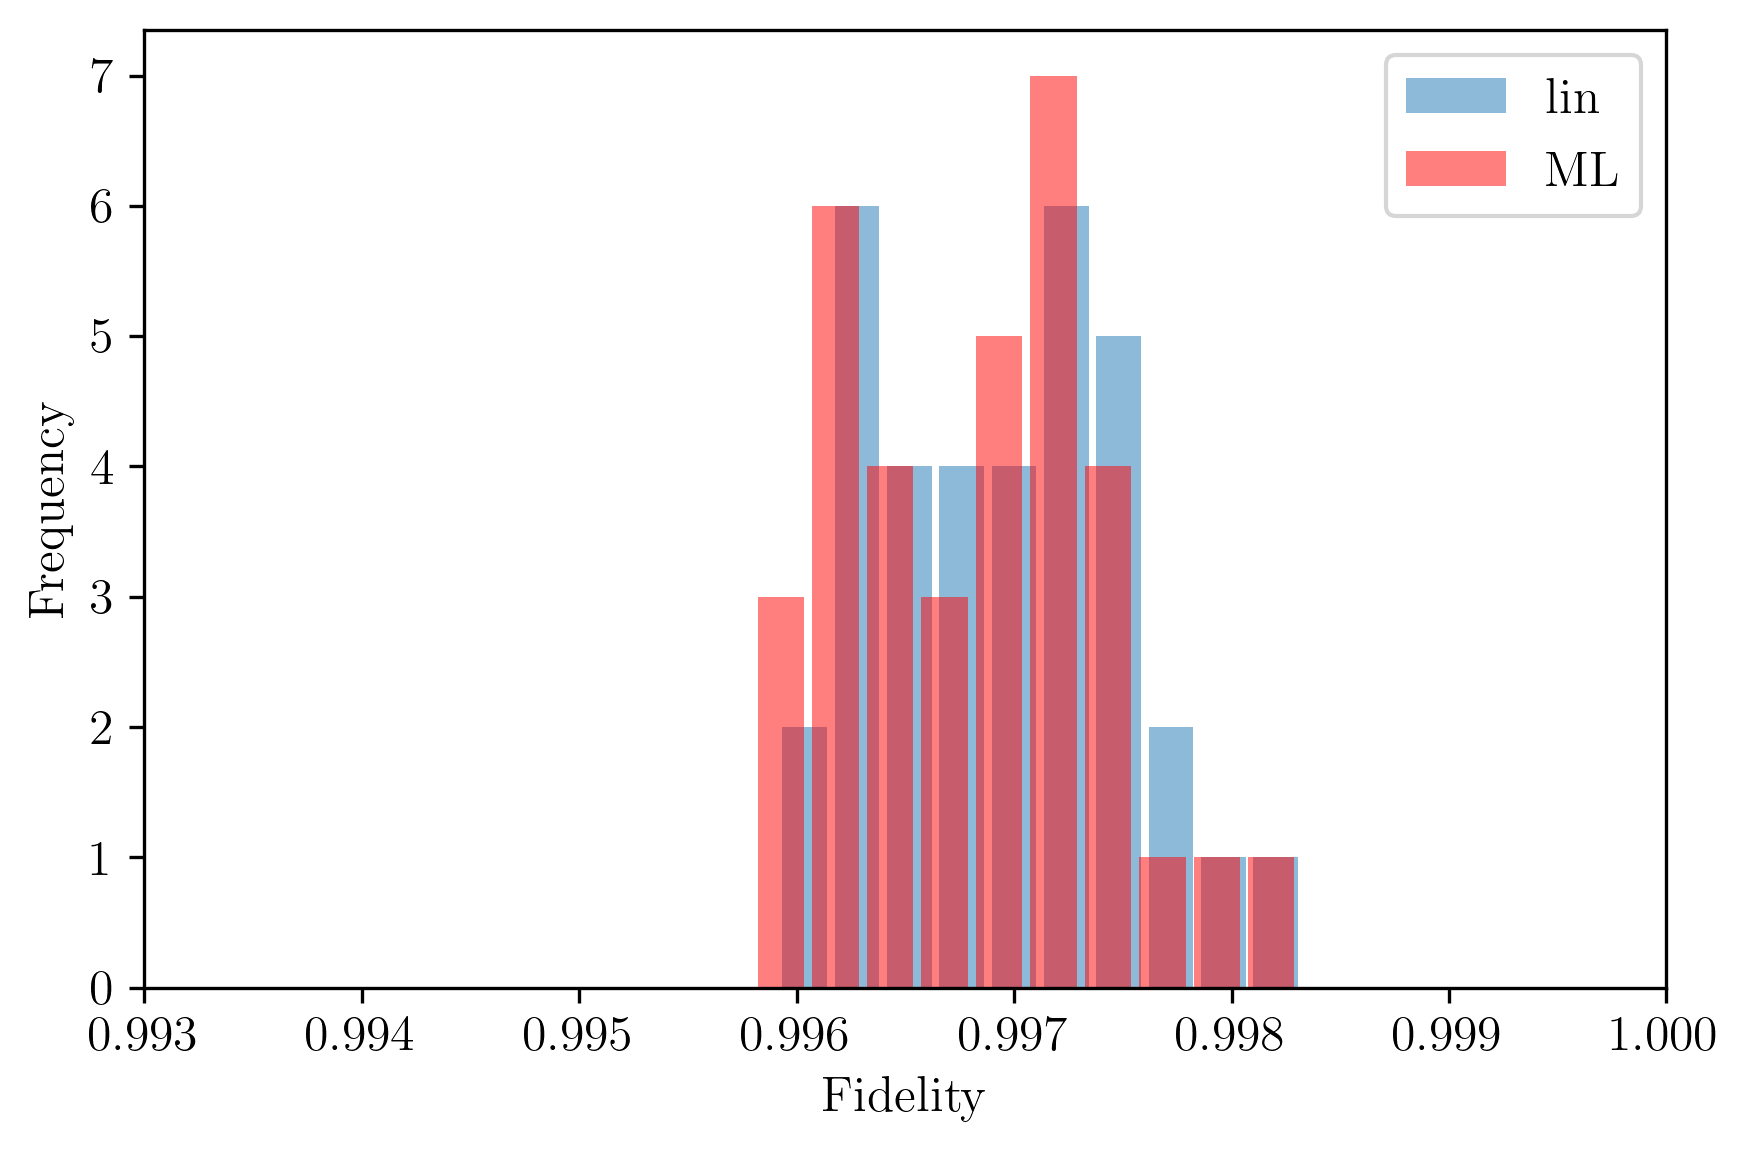

In [30]:
# Make x-y points
X = np.arange(n_qbits**2)
Y = np.arange(n_qbits**2)

X, Y = np.meshgrid(X, Y)

Xi = X.flatten()
Yi = Y.flatten()
Zi = np.zeros(rho_lin_mean.size)

dx = .75 * np.ones(rho_lin_mean.size)
dy = .75 * np.ones(rho_lin_mean.size)
dz_re = np.real(rho_lin_mean).flatten()
dz_im = np.imag(rho_lin_mean).flatten()

fig1 = plt.figure(figsize=(12, 4), dpi=150)

# set up the axes for the first plot
cmap1=plt.cm.rainbow(plt.Normalize(-.5,.5)(dz_re))

ax1 = fig1.add_subplot(1, 3, 1, projection='3d')
ax1.bar3d(Xi, Yi, Zi, dx, dy, dz_re, color=cmap1)


# Customize the axis.
labs = [r'$\left|HH\right\rangle$',r'$\left|HV\right\rangle$',
        r'$\left|VH\right\rangle$',r'$\left|VV\right\rangle$']
ax1.set_xticks([0,1,2,3])
ax1.set_xticklabels(labs,ha='center', va='bottom')
ax1.set_yticks([0,1,2,3])
ax1.set_yticklabels(labs,ha='left', va='bottom')
ax1.set_zlim(-.05,.5)

# set up the axes for the second plot
ax2 = fig1.add_subplot(1, 3, 2, projection='3d')
cmap2=plt.cm.rainbow(plt.Normalize(-.5,.5)(dz_im))
ax2.bar3d(Xi, Yi, Zi, dx, dy, dz_im, color=cmap2)
ax2.set_xticks([0,1,2,3])
ax2.set_xticklabels(labs,ha='center', va='bottom')
ax2.set_yticks([0,1,2,3])
ax2.set_yticklabels(labs,ha='left', va='bottom')
#ax2.set_zticks([0,.2,.4])
ax2.set_zlim(-.05,.5)

# add colorbar
#ax3 = fig1.add_subplot(1, 3, 3)
m = plt.cm.ScalarMappable(cmap=cm.rainbow)
#m.set_array(np.real(rho_lin_mean))
m.set_array(np.real(rho_ML_mean))
m.set_clim(-.5, .5)
#plt.gca().set_visible(False)


axins = inset_axes(ax2,
                   width="3%",  # width = 5% of parent_bbox width
                   height="50%",  # height : 50%
                   loc='center left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax2.transAxes,
                   borderpad=2,
                   )
fig1.colorbar(m, cax=axins, shrink=1, aspect=20)

plt.tight_layout()
ax1.view_init(20, -60)
ax2.view_init(20, -60)
plt.draw()

# plot fidelity histogram
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=300)
n_lin,bins_lin,patches_lin = ax.hist(fid_list, alpha=0.5, rwidth = .85, label='lin')
ax.hist(fid_list_ML, alpha=.5, rwidth = .85, color='r', label='ML')
ax.legend()
ax.set_xlim(.993,1)
ax.set_xlabel('Fidelity')
ax.set_ylabel('Frequency')
fig.tight_layout()
plt.draw()

# fidelity in time
#fig_ft, ax = plt.subplots(nrows=1, ncols=1, dpi=150)
#ax.plot(fid_list)
fig1.savefig("rho_2ph_lin.pdf", format='pdf', bbox_inches='tight')
fig.savefig("rho_2ph_histogram_lin_vs_ML.pdf", format='pdf', bbox_inches='tight')
# show plots
#plt.show()